In [1]:
from app.models import Session, Headline, Agency, Article
from app.utils import Country, Bias, Credibility
from app.analysis.clustering import prepare_cosine, form_clusters, label_clusters
import pandas as pd

In [2]:
with Session() as s:
    data = s.query(Headline.id, Headline.processed, Headline.first_accessed, Article.url, Agency.name, Agency._country, Agency._bias, Agency._credibility).join(Headline.article).join(Article.agency).all()
    df = pd.DataFrame(data, columns=['id', 'headline', 'date', 'url', 'agency', 'country', 'bias', 'credibility'])

In [3]:
df.sample(15)

,id,headline,date,url,agency,country,bias,credibility
387580,467018,'Never Seen Any Fast Bowler in India...': Rohi...,2024-03-21 08:30:02.621906,https://www.news18.com/cricket/never-seen-any-...,News 18,4,1,2
713013,821027,Democrats Seize Control of House Speaker Johns...,2024-04-19 14:00:03.301078,https://www.breitbart.com/politics/2024/04/18/...,Breitbart,0,3,2
704577,812589,More on the US-Israel Rafah meeting,2024-04-18 21:30:04.877743,https://www.aljazeera.com/news/liveblog/2024/4...,Al Jazeera,2,-1,2
1052648,1190312,JSW Steel's Q4 profit slips 65% as input costs...,2024-05-17 13:30:03.234022,https://www.livemint.com/companies/company-res...,livemint.com,4,0,2
239310,284189,Landlord accused of stalking tenant left her 1...,2024-03-08 22:50:02.690369,http://news.yahoo.com/landlord-accused-stalkin...,Yahoo News,0,-1,4
380614,458464,The Minnesota Department of Corrections has pe...,2024-03-20 18:10:02.048284,https://apnews.com/article/minnesota-jail-inma...,AP,0,-1,4
77809,92646,"Kawhi Leonard scored 24 points, Terance Mann h...",2024-02-24 03:50:03.722625,https://apnews.com/article/clippers-grizzlies-...,AP,0,-1,4
200230,238468,"DMK Raja's remarks on India, Ram: BJP hits bac...",2024-03-05 23:30:01.672644,https://indianexpress.com/article/political-pu...,The Indian Express,4,-1,2
626075,734041,Stock market today: Global markets mixed after...,2024-04-12 10:30:02.657482,https://apnews.com/article/stock-markets-share...,AP,0,-1,4
14279,16517,When Esha Deol wanted to be a runaway bride,2024-02-18 06:40:03.225475,https://timesofindia.indiatimes.com/entertainm...,The Times of India,4,1,2


In [4]:
from app.utils import Config
df = df[(df['country'] == Country.us.value) | ((df['country'] == Country.gb.value) & (df['agency'].isin(Config.exempted_foreign_media)))]

In [5]:
import pytz
# Cast date as utc and then convert it to the NYC eastern
df['day'] = df['date'].apply(lambda x: x.date())
df.sample(5)

,id,headline,date,url,agency,country,bias,credibility,day
822110,930992,Elon Musk in China to discuss enabling Full Se...,2024-04-29 10:30:04.726025,https://news.yahoo.com/tech/elon-musk-china-di...,Yahoo News,0,-1,4,2024-04-29
390562,470495,Five reasons the Trump campaign needs more mon...,2024-03-21 12:50:02.670967,https://thehill.com/opinion/campaign/4545623-f...,The Hill,0,0,3,2024-03-21
770467,878486,'I get overwhelmed by the noises and crowds of...,2024-04-24 17:30:03.770685,https://www.bbc.com/news/uk-68831018,BBC,1,-1,4,2024-04-24
545782,648453,European Commission examines complaint about H...,2024-04-05 07:00:02.585234,https://www.reuters.com/business/retail-consum...,Reuters,1,0,5,2024-04-05
823331,932214,'Affectionate' Taylor Swift and Travis Kelce s...,2024-04-29 12:00:02.990933,https://pagesix.com/2024/04/29/entertainment/a...,New York Post,0,1,2,2024-04-29


In [6]:
# SPlit the df into dfs for days
dfs = [df[df['day'] == day].copy() for day in df['day'].unique()]
dfs[0].head()

,id,headline,date,url,agency,country,bias,credibility,day
0,1,Schweizer's 'Blood Money' Rockets to #1 on Ama...,2024-02-16 20:07:42,https://www.breitbart.com/politics/2024/02/15/...,Breitbart,0,3,2,2024-02-16
1,2,Who Can Win a Nobel Prize? by Yasmin Nair,2024-02-16 20:07:43,https://www.currentaffairs.org/2024/01/who-can...,Current Affairs,0,-2,4,2024-02-16
4,5,"To Russia, With Love, From GOP",2024-02-16 20:07:45,https://crooksandliars.com/2024/02/russia-love...,Crooks and Liars,0,-2,3,2024-02-16
6,7,Al Capone's Miami property is on the market fo...,2024-02-16 20:07:46,https://www.businessinsider.com/former-al-capo...,Business Insider,0,-1,3,2024-02-16
8,9,Legal Analyst: It's 'Game Over' if Fani Willis...,2024-02-16 20:07:47,https://www.breitbart.com/clips/2024/02/15/leg...,Breitbart,0,3,2,2024-02-16


In [7]:
n_samples = 10
threshold = 0.5
dfs = [label_clusters(df, form_clusters(prepare_cosine(df['headline']), n_samples, 0.5)) for df in dfs]
df = pd.concat(dfs)
df.sample(5)

,id,headline,date,url,agency,country,bias,credibility,day,cluster
884958,994150,The Balkan gangsters who became Europe's top c...,2024-05-04 10:30:04.696975,https://www.reuters.com/podcasts/balkan-gangst...,Reuters,1,0,5,2024-05-04,-1
145842,172437,The Environmental Protection Agency said Thurs...,2024-03-01 00:00:01.725781,https://apnews.com/article/epa-power-plants-cl...,AP,0,-1,4,2024-03-01,-1
870448,979620,Whistleblower who worked for Boeing supplier d...,2024-05-02 19:00:02.930848,https://www.usatoday.com/story/travel/airline-...,USA Today,0,-1,3,2024-05-02,-1
341083,410612,'A national security nightmare': How Trump's d...,2024-03-17 20:00:02.133121,https://www.msnbc.com/weekends-with-alex-witt/...,MSNBC,0,-2,2,2024-03-17,-1
342920,413020,A man has fallen to his death from a hot-air b...,2024-03-18 02:00:02.182644,https://apnews.com/article/ballooning-death-me...,AP,0,-1,4,2024-03-18,-1


In [8]:
# Drop -1's from the cluster column
df = df[df['cluster'] != -1]
# Combine day and clusterid to get a unique identifier
df['clusterid'] = df['day'].astype(str) + df['cluster'].astype(str)

# Drop duplicates within each cluster (sometimes an agency will have more than one headline in a cluster)
df = df.drop_duplicates(subset=['clusterid', 'agency'])
# Drop clusters with less than 10 agencies
df = df.groupby('clusterid').filter(lambda x: len(x) >= 10)

In [9]:
# Now we want to count entries per day
counts = df.groupby('day').size()

In [10]:
# Rename unnamed
counts.rename('count', inplace=True)
counts.sample(10)

day
2024-04-24    360
2024-03-30     76
2024-03-13    401
2024-04-11    281
2024-04-23    293
2024-03-26    344
2024-05-13    334
2024-03-06    277
2024-05-15    491
2024-02-28    498
Name: count, dtype: int64

<Axes: xlabel='day'>

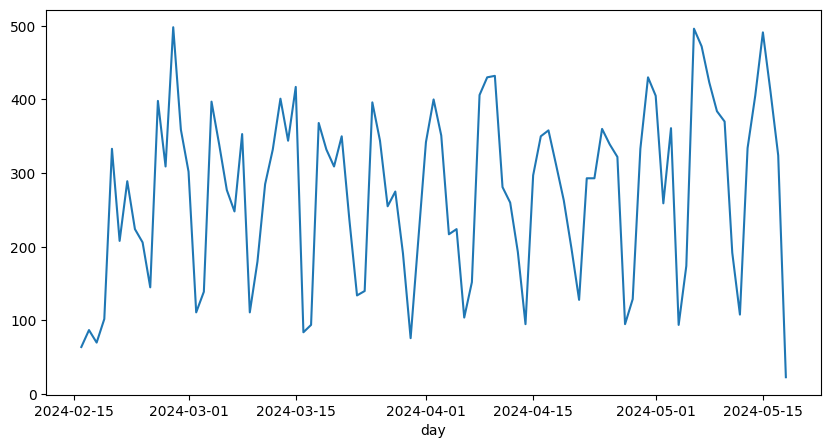

In [11]:
import matplotlib.pyplot as plt

# Now plot the counts
plt.figure(figsize=(10, 5))
counts.plot()


In [14]:
counts = counts.reset_index()
counts.sample(10)

,day,count
77,2024-05-04,94
44,2024-04-01,342
17,2024-03-04,397
8,2024-02-24,206
59,2024-04-16,350
58,2024-04-15,297
16,2024-03-03,139
54,2024-04-11,281
40,2024-03-27,255
68,2024-04-25,339


In [17]:
# Let's take the median, then we mark slow and busy news days based on the median
median = counts.median()
counts['slow'] = counts['count'] < median
counts.sample(10)

TypeError: setting an array element with a sequence.

In [18]:
median

295.0

In [22]:
counts['count']

0                                                    64
1                                                    87
2                                                    70
3                                                   102
4                                                   333
                            ...                        
88                                                  491
89                                                  410
90                                                  324
91                                                   23
92    day
2024-02-16     True
2024-02-17     True
20...
Name: count, Length: 93, dtype: object

In [23]:
import pandas as pd

# Example DataFrame
data = {'count': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
counts = pd.DataFrame(data)

# Calculate the median
median = counts['count'].median()
print("Median is:", median)

# Create a new column based on the median
counts['slow'] = counts['count'] < median

# Sample the DataFrame
print(counts.sample(10))

Median is: 5.5
   count   slow
8      9  False
5      6  False
7      8  False
0      1   True
6      7  False
4      5   True
9     10  False
3      4   True
2      3   True
1      2   True
